In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [100]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifex = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()
print(lifex.columns)
lifex.head(10)
pd.set_option('display.max_columns', None)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


1. Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it. <br>
First, load the dataset.


2. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

Many of the lines for South Sudan are missing values in at least eight columns. Most of the lines for the Democratic People's Republic of Korea, Democratic Republic of the Congo, Somalia, South Sudan, and United Kingdom of Great Britain and Northern Ireland are missing values in at least five columns. No row is missing values in more than nine columns, so I don't think dropping any rows is warranted. 

There are 1,728 rows with BMI greater than or equal to 31, which is currently the definition of obese. I don't like using BMI to measure health, but it's still surprising to see so many countries with such a large average individual. I may delete/disregard this column. 

There seems to be quite a few problems with the population problem. For starters, there are 118 rows with populations under 10,000, none of which shold show that low. The population for China is far below what it should be, and there are no values in the Population column for the United States. Again, I may disregard this column.

Seemingly the most egregious outliers are Infant Deaths, Percentage Expenditure, Measles, Under-Five Deaths, GDP, and Population. It doesn't look like there are any 'nonsense' values in these outliers, so I don't see a need to remove any rows. I'm going to interpolate to fill missing values and then apply the winsorize function or log or square root tranformations in an attempt to minimize the outliers.

Finally, I'll normalize the data.

In [101]:
null_columns=lifex.columns[lifex.isnull().any()]
lifex[null_columns].isnull().sum()
lifex.isnull().sum()
lifex.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.000000,2919.000000,2938.000000,2490.000000,2286.000000,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.938190,82.324084,1.742103,7483.158469,12753375.120052,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.498320,23.716912,5.077785,14270.169342,61012096.508428,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,34.000000,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.260000,78.000000,0.100000,463.935626,195793.250000,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.755000,93.000000,0.100000,1766.947595,1386542.000000,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.492500,97.000000,0.800000,5910.806335,7420359.000000,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1293859294.000000,27.700000,28.600000,0.948000,20.700000


In [102]:
lifex.interpolate(method ='linear', limit=None,inplace=True, limit_direction='both', limit_area=None, downcast=None)
# pd.set_option('float_format', '{:f}'.format)
# print(lifex.columns)
# lifex.head(10)

In [103]:
# winsorized_id = winsorize(lifex["infant deaths"], (0, 0.10))
# winsorized_percexp = winsorize(lifex["percentage expenditure"], (0, 0.10))
# winsorized_measles = winsorize(lifex["Measles "], (0, 0.10))
# winsorized_u5d = winsorize(lifex['under-five deaths '], (0, 0.10))
# winsorized_gdp = winsorize(lifex['GDP'], (0, 0.10))
# winsorized_pop = winsorize(lifex['Population'], (0, 0.10))

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# sns.boxplot(winsorized_id)
# plt.title('Winsorized Infant Deaths')
# plt.subplot(1,2,1)
# sns.boxplot(x='infant deaths', data=lifex)
# plt.title('Original Infant Deaths Data')

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# sns.boxplot(winsorized_percexp)
# plt.title('Winsorized Percentage Expenditure')
# plt.subplot(1,2,1)
# sns.boxplot(x='percentage expenditure', data=lifex)
# plt.title('Original Percentage Expenditure Data')

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# sns.boxplot(winsorized_measles)
# plt.title('Winsorized Measles')
# plt.subplot(1,2,1)
# sns.boxplot(x='Measles ', data=lifex)
# plt.title('Original Measles Data')

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# sns.boxplot(winsorized_gdp)
# plt.title('Winsorized GDP')
# plt.subplot(1,2,1)
# sns.boxplot(x='GDP', data=lifex)
# plt.title('Original GDP Data')

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# sns.boxplot(winsorized_u5d)
# plt.title('Winsorized Under-Five Deaths')
# plt.subplot(1,2,1)
# sns.boxplot(x='under-five deaths ', data=lifex)
# plt.title('Original Under-Five Deaths Data')

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# sns.boxplot(winsorized_pop)
# plt.title('Winsorized Population')
# plt.subplot(1,2,1)
# sns.boxplot(x='Population', data=lifex)
# plt.title('Original Population Data')

In [87]:
# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# plt.boxplot(np.sqrt(lifex['infant deaths']))
# plt.title('Square Rooted Infant Deaths')
# plt.subplot(1,2,1)
# plt.boxplot(np.log(lifex['infant deaths']))
# plt.title('Log Infant Deaths')
# plt.show()

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# plt.boxplot(np.sqrt(lifex['percentage expenditure']))
# plt.title('Square Rooted Percentage Expenditure')
# plt.subplot(1,2,1)
# plt.boxplot(np.log(lifex['percentage expenditure']))
# plt.title('Log Percentage Expenditure')

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# plt.boxplot(np.sqrt(lifex['under-five deaths ']))
# plt.title('Square Rooted Under-Five Deaths')
# plt.subplot(1,2,1)
# plt.boxplot(np.log(lifex['under-five deaths ']))
# plt.title('Log Under-Five Deaths')

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)           
# plt.boxplot(np.sqrt(lifex['Measles ']))
# plt.title('Square Rooted Measles')
# plt.subplot(1,2,1)
# plt.boxplot(np.log(lifex['Measles ']))
# plt.title('Log Measles')
# plt.show()

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2) 
# plt.boxplot(np.sqrt(lifex['GDP']))
# plt.title('Square Rooted GDP')
# plt.subplot(1,2,1)
# plt.boxplot(np.log(lifex['GDP']))
# plt.title('Log GDP')
# plt.show()          

# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# plt.boxplot(np.sqrt(lifex['Population']))
# plt.title('Square Rooted Population')
# plt.subplot(1,2,1)
# plt.boxplot(np.log(lifex['Population']))
# plt.title('Log Population')


# plt.figure(figsize = (15,5))
# plt.subplot(1,2,2)
# population_boxcox,_ = boxcox(lifex["Population"])
# plt.boxplot(population_boxcox)
# plt.title(" Population Box-Cox Transformed")

In [88]:
# lifex['infant deaths'] = np.sqrt(lifex['infant deaths'])
# lifex['percentage expenditure'] = np.sqrt(lifex['percentage expenditure'])
# lifex['under-five deaths '] = np.sqrt(lifex['under-five deaths '])
# lifex['Measles '] = np.sqrt(lifex['Measles '])
# lifex['GDP'] = np.sqrt(lifex['GDP'])
# lifex['Population'] = population_boxcox

# pd.set_option('display.max_columns', None)
# lifex.head(10)

3. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

The correlation table gives some interesting insight. There are small but positive correlations between life expectancy and Diptheria as well as Polio. My explanation for this is that perhaps these diseases are difficult to diagnose and are therefore only being recorded in countries with the means to record them. There are also small but positive correlations between life expectancy and GDP and BMI, which is not too surprising. The two variables most strongly correlated with life expectancy are income composition of resources and schooling. The two variables with the strongest negative correlation with life expectancy are adult mortality and HIV/AIDS.

Some variables we may be able to combine are infant deaths and under-five deaths as well as thinness 1-19 years and thinness 5-9 years.

In [104]:
# Categorizing columns Status, BMI, Measles

lifex = pd.concat([lifex, pd.get_dummies(lifex["Status"])], axis=1)

lifex['BMI Range'] = ['underweight' if x <= 18.5 else 'healthy' if 18.5 < x <= 24.9 else 'overweight' if 24.9 < x <=29.9 else 'obese' for x in lifex[' BMI ']]
lifex = pd.concat([lifex, pd.get_dummies(lifex["BMI Range"])], axis=1)   

lifex['Measles (Y/N)'] = ['Measles No' if x == 0 else 'Measles Yes' for x in lifex['Measles ']]
lifex = pd.concat([lifex, pd.get_dummies(lifex["Measles (Y/N)"])], axis=1)   

lifex['Infant Deaths (Y/N)'] = ['Infant Deaths No' if x == 0 else 'Infant Deaths Yes' for x in lifex['infant deaths']]
lifex = pd.concat([lifex, pd.get_dummies(lifex["Infant Deaths (Y/N)"])], axis=1) 

lifex['Percentage Expenditure Above (Y/N)'] = ['Percentage Expenditure 0' if x == 0 else 'Percentage Expenditure Above 0' for x in lifex['percentage expenditure']]
lifex = pd.concat([lifex, pd.get_dummies(lifex["Percentage Expenditure Above (Y/N)"])], axis=1)

lifex['GDP Level'] = ['low' if x <= 20000 else 'medium' if 20000 < x <= 40000 else 'high' for x in lifex['GDP']]
lifex = pd.concat([lifex, pd.get_dummies(lifex["GDP Level"])], axis=1)  

    
lifex.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developed,Developing,healthy,obese,overweight,underweight,Measles No,Measles Yes,Infant Deaths No,Infant Deaths Yes,Percentage Expenditure 0,Percentage Expenditure Above 0,high,low,medium
Year,1.000000,0.168309,-0.079264,-0.037415,-0.064487,0.031400,0.145777,-0.082493,0.100417,-0.042937,0.095580,0.079345,0.135174,-0.139741,0.089699,0.019915,-0.038570,-0.040661,0.223818,0.185780,-0.001864,0.001864,0.093203,0.031081,0.008765,-0.111334,0.044425,-0.044425,0.045776,-0.045776,0.209626,-0.209626,0.095281,-0.021166,-0.054244
Life expectancy,0.168309,1.000000,-0.695730,-0.196197,0.400068,0.382069,0.247419,-0.157298,0.556433,-0.222151,0.459865,0.210843,0.474084,-0.555929,0.435854,-0.007126,-0.476809,-0.472485,0.690071,0.703409,0.482287,-0.482287,-0.325661,0.560897,-0.141675,-0.328450,0.176453,-0.176453,0.407441,-0.407441,-0.018211,0.018211,0.266982,-0.379997,0.258123
Adult Mortality,-0.079264,-0.695730,1.000000,0.078762,-0.194070,-0.242587,-0.162578,0.031226,-0.383224,0.094134,-0.272553,-0.116293,-0.273311,0.523245,-0.283332,-0.025440,0.307734,0.314769,-0.440536,-0.430481,-0.314608,0.314608,0.213803,-0.375153,0.165120,0.181819,-0.117180,0.117180,-0.297079,0.297079,0.051246,-0.051246,-0.171248,0.256779,-0.182244
infant deaths,-0.037415,-0.196197,0.078762,1.000000,-0.114836,-0.085612,-0.200825,0.501128,-0.226540,0.996629,-0.169385,-0.126114,-0.173944,0.025231,-0.107450,0.538589,0.462953,0.467439,-0.132327,-0.173790,-0.112252,0.112252,0.107033,-0.245585,-0.014034,0.214680,-0.157820,0.157820,-0.163714,0.163714,-0.023655,0.023655,-0.053935,0.084587,-0.062147
Alcohol,-0.064487,0.400068,-0.194070,-0.114836,1.000000,0.337902,0.092366,-0.050497,0.319618,-0.112036,0.222830,0.289631,0.218683,-0.048190,0.342275,-0.029223,-0.420123,-0.408260,0.442169,0.507064,0.584888,-0.584888,-0.172277,0.309219,-0.068680,-0.191993,0.090738,-0.090738,0.307719,-0.307719,-0.016924,0.016924,0.183250,-0.277399,0.198372
percentage expenditure,0.031400,0.382069,-0.242587,-0.085612,0.337902,1.000000,-0.033524,-0.056596,0.228084,-0.087852,0.147584,0.169770,0.144017,-0.097857,0.871453,-0.016310,-0.252133,-0.253622,0.359488,0.369717,0.454261,-0.454261,-0.097266,0.195026,-0.056277,-0.122110,-0.028659,0.028659,0.247808,-0.247808,-0.190328,0.190328,0.749967,-0.738123,0.303939
Hepatitis B,0.145777,0.247419,-0.162578,-0.200825,0.092366,-0.033524,1.000000,-0.129531,0.172639,-0.208634,0.446056,0.088999,0.532925,-0.117155,0.031839,-0.080645,-0.141744,-0.150593,0.193478,0.201451,0.096169,-0.096169,-0.120449,0.188117,-0.021530,-0.116829,0.106796,-0.106796,0.123665,-0.123665,0.024051,-0.024051,-0.028373,0.008391,0.013483
Measles,-0.082493,-0.157298,0.031226,0.501128,-0.050497,-0.056596,-0.129531,1.000000,-0.175347,0.507809,-0.135067,-0.102920,-0.140774,0.030899,-0.067382,0.229798,0.222427,0.217983,-0.087650,-0.082928,-0.076955,0.076955,0.091172,-0.198137,0.008075,0.158319,-0.149644,0.149644,-0.132461,0.132461,0.001701,-0.001701,-0.041737,0.050777,-0.029318
BMI,0.100417,0.556433,-0.383224,-0.226540,0.319618,0.228084,0.172639,-0.175347,1.000000,-0.236850,0.282080,0.233848,0.280483,-0.243181,0.271717,-0.060964,-0.533952,-0.540459,0.461457,0.488210,0.310400,-0.310400,-0.295818,0.895693,-0.142308,-0.741520,0.180743,-0.180743,0.316593,-0.316593,0.012313,-0.012313,0.177825,-0.206820,0.112739
under-five deaths,-0.042937,-0.222151,0.094134,0.996629,-0.112036,-0.087852,-0.208634,0.507809,-0.236850,1.000000,-0.187343,-0.127707,-0.194375,0.038062,-0.110803,0.526147,0.465291,0.468655,-0.149759,-0.188784,-0.115195,0.115195,0.112662,-0.257392,-0.016128,0.225462,-0.162391,0.162391,-0.166618,0.166618,-0.025804,0.025804,-0.055168,0.086465,-0.063498


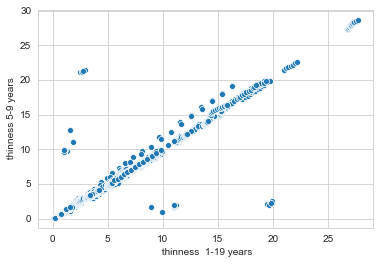

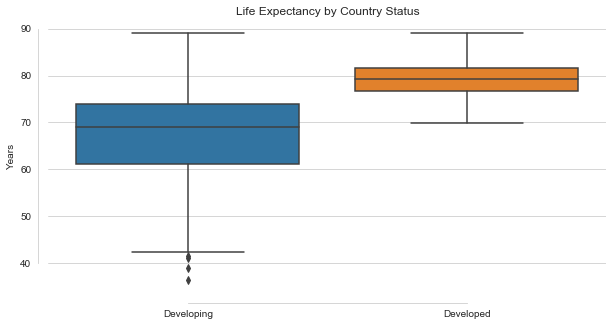

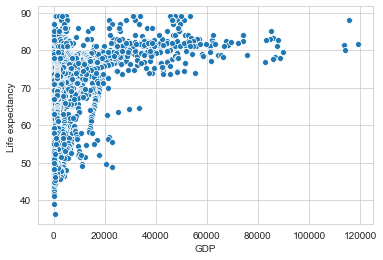

In [98]:
thinness = lifex[[' thinness  1-19 years', ' thinness 5-9 years']]
sns.scatterplot(x=' thinness  1-19 years', y=' thinness 5-9 years', data=lifex)
thinness.corr()


plt.show()

sns.scatterplot(x='GDP', y='Life expectancy ', data=lifex)

4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

I'm going to remove the following variables due to redundancy and/or irrelevance:
- thinness 5-9 years
- under-5 deaths
- year
- population


In [67]:
lifex1 = lifex.drop(['Year', 'infant deaths', ' thinness 5-9 years', 'Population'], axis=1)
lifex1.head()


,Country,Status,Life expectancy,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,Income composition of resources,Schooling,Developed,Developing
0,Afghanistan,Developing,65.000000,263.000000,0.010000,8.442726,65.000000,33.970576,19.100000,9.110434,6.000000,8.160000,65.000000,0.100000,24.171454,17.200000,0.479000,10.100000,0,1
1,Afghanistan,Developing,59.900000,271.000000,0.010000,8.574589,62.000000,22.181073,18.600000,9.273618,58.000000,8.180000,62.000000,0.100000,24.752707,17.500000,0.476000,10.000000,0,1
2,Afghanistan,Developing,59.900000,268.000000,0.010000,8.556824,64.000000,20.736441,18.100000,9.433981,62.000000,8.130000,64.000000,0.100000,25.134538,17.700000,0.470000,9.900000,0,1
3,Afghanistan,Developing,59.500000,272.000000,0.010000,8.842184,67.000000,52.792045,17.600000,9.643651,67.000000,8.520000,67.000000,0.100000,25.883566,17.900000,0.463000,9.800000,0,1
4,Afghanistan,Developing,59.200000,275.000000,0.010000,2.664040,68.000000,54.890801,17.200000,9.848858,68.000000,7.870000,68.000000,0.100000,7.971024,18.200000,0.454000,9.500000,0,1


,Country,Status,Life expectancy,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,Income composition of resources,Schooling,Developed,Developing
0,Afghanistan,Developing,65.000000,263.000000,0.010000,8.442726,65.000000,33.970576,19.100000,9.110434,6.000000,8.160000,65.000000,0.100000,24.171454,17.200000,0.479000,10.100000,0,1
1,Afghanistan,Developing,59.900000,271.000000,0.010000,8.574589,62.000000,22.181073,18.600000,9.273618,58.000000,8.180000,62.000000,0.100000,24.752707,17.500000,0.476000,10.000000,0,1
2,Afghanistan,Developing,59.900000,268.000000,0.010000,8.556824,64.000000,20.736441,18.100000,9.433981,62.000000,8.130000,64.000000,0.100000,25.134538,17.700000,0.470000,9.900000,0,1
3,Afghanistan,Developing,59.500000,272.000000,0.010000,8.842184,67.000000,52.792045,17.600000,9.643651,67.000000,8.520000,67.000000,0.100000,25.883566,17.900000,0.463000,9.800000,0,1
4,Afghanistan,Developing,59.200000,275.000000,0.010000,2.664040,68.000000,54.890801,17.200000,9.848858,68.000000,7.870000,68.000000,0.100000,7.971024,18.200000,0.454000,9.500000,0,1


Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

The variables/features I would use in my model are Infant Deaths, Status, Schooling, Income Composition of resources, thinness 1-19, adult mortality, bmi (obesity), and HIV/AIDS. I don't really understand how splitting up GDP, BMI, infant deaths, and measles helped - the correlation matrix gave me all the information I needed.

[Text(0, 0.5, 'Years'), Text(0.5, 0, '')]

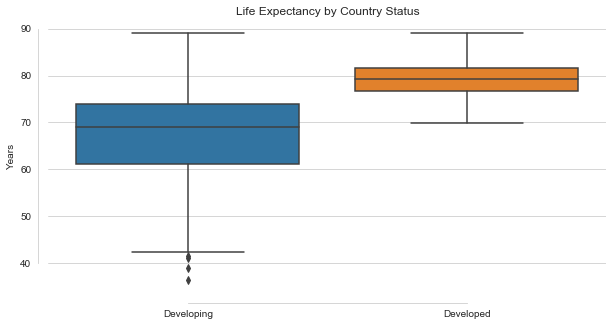

In [105]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(x='Status',y='Life expectancy ',data=lifex)  
plt.title('Life Expectancy by Country Status')
sns.despine(offset=10, trim=True)
ax.set(xlabel='', ylabel='Years')

Text(0.5, 1.0, 'Life Exptectancy by Infant Deaths')

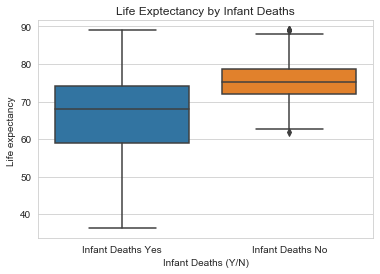

In [109]:
sns.boxplot(x='Infant Deaths (Y/N)', y='Life expectancy ', data=lifex)
plt.title('Life Exptectancy by Infant Deaths')

Text(0.5, 1.0, 'Life Exptectancy by Schooling')

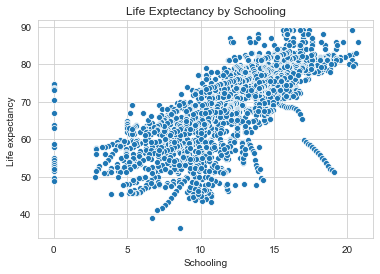

In [111]:
sns.scatterplot(x='Schooling', y='Life expectancy ', data=lifex)
plt.title('Life Exptectancy by Schooling')

Text(0.5, 1.0, 'Life Expectancy by Schooling Income Composition of Resources ')

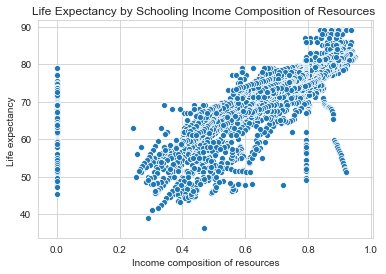

In [115]:
sns.scatterplot(x='Income composition of resources', y='Life expectancy ', data=lifex)
plt.title('Life Expectancy by Income Composition of Resources ')

Text(0.5, 1, 'Life Expectancy by Thinness Ages 1-19')

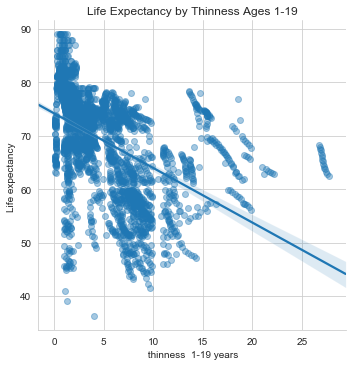

In [130]:
sns.lmplot(x=' thinness  1-19 years', y='Life expectancy ', data=lifex, fit_reg=True, scatter_kws={'alpha':0.4})
plt.title('Life Expectancy by Thinness Ages 1-19')


Text(0.5, 1, 'Life Expectancy by Adult Mortality')

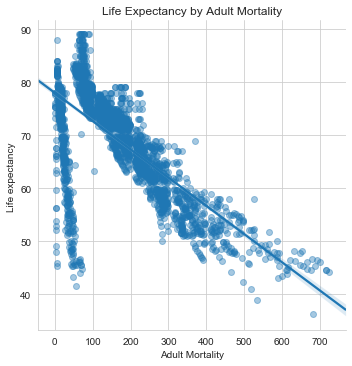

In [129]:
sns.lmplot(x='Adult Mortality', y='Life expectancy ', data=lifex, fit_reg=True, scatter_kws={'alpha':0.4})
plt.title('Life Expectancy by Adult Mortality')

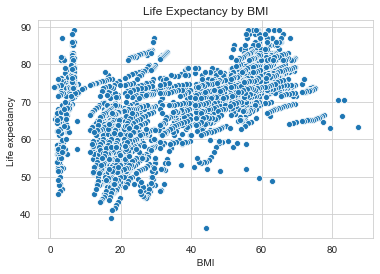

Text(0.5, 1.0, 'Life Expectancy by BMI')

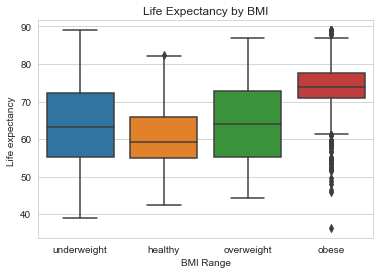

In [121]:
sns.scatterplot(x=' BMI ', y='Life expectancy ', data=lifex)
plt.title('Life Expectancy by BMI')
plt.show()

sns.boxplot(x='BMI Range', y='Life expectancy ', data=lifex, order=['underweight', 'healthy', 'overweight', 'obese'])
plt.title('Life Expectancy by BMI')

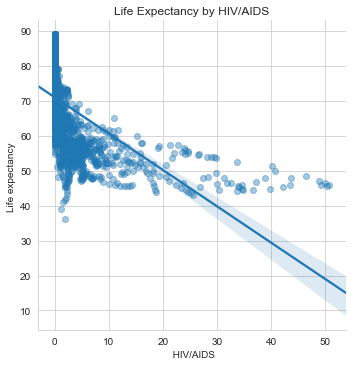

In [128]:
sns.lmplot(x=' HIV/AIDS', y='Life expectancy ', data=lifex, fit_reg=True, scatter_kws={'alpha':0.4})
plt.title('Life Expectancy by HIV/AIDS')
plt.show()